## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from datetime import datetime, timedelta
from itertools import product

## Binary outcome & simulation: Arithmetic betting & risk-of-ruin

### Binary game simulation function

In [2]:
def getSim_binaryFixAmount(initAmount=100, a=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """
    Obtain dictionary of equal-amount-bet simulation results.
    initAmount: initial amount for betting
    f: percent per bet
    p: winning probability
    b: reward-to-risk ratio (/ odds)
    numTrialss: number of trials of the same binary game
    numSim: number of binary simulations
    """
    # Dict for recording different series of profit/loss
    simDict = {}
    # Dict for recording different series of capital (total equity)
    amountDict = {}
    # Generate a total of `numSim`= N series of binary game result and P/L
    stepFunc = lambda x: 1 if x > 0 else 0  # Lambda Function for getting "1" with a fixed prob and "0" otherwise
    for num in range(numSim):
        # Generate a series of "1"/"0" with probability p
        signArray = np.array([stepFunc(r) for r in np.random.uniform(p - 1, p, numTrials)])
        # Series of asset increment on win/loss result (EITHER increase by a * b OR decrease by a)
        trialArray = a * ((b + 1) * signArray - 1)
        # Record the asset increment series into `simDict`
        simDict[num + 1] = trialArray
        # Array of total equity and record into `amountDict`
        amountArray = initAmount + trialArray.cumsum()
        # IF equity drops below the fixed bet amount, stop betting
        period = 1
        while period <= numTrials - 1:
            if amountArray[period] < a:
                for j in range(period, numTrials):
                    amountArray[j] = amountArray[period]
                amountDict[f's{num}'] = amountArray
                break
            period += 1
        amountDict[f's{num + 1}'] = amountArray
    # Form dataframe from the `amountDict` and transpose, so that each row corresponds to a betting series
    dfSim = pd.DataFrame(amountDict).transpose()
    # Rename columns so that each number in column labels corresponds to the k-th trial
    dfSim = dfSim.rename(columns={k: (k + 1) for k in dfSim.columns})

    return dfSim

### Performance KPIs: winning rate, RRR (Realized reward-risk ratio), profit factor

In [3]:
def getProfitfactor(p, b):
    """Get profit factor of a binary game."""
    return round(p * b / (1 - p), 4)

def getOdds(p, pf):
    """Given fixed winning rate and profit factor, find odds (or reward-risk ratio)."""
    return pf * (1 - p) / p

def getWinrate(b, pf):
    """Given fixed odds and profit factor, find winning rate."""   
    return pf / (pf + b)

### Sample simulation: 20 trials, 30 simulations, converted into dataframe

In [4]:
initAmount0 = 100  # Initial capital
a0 = 20  # Fixed amount per bet
p0 = 0.5   # winning probability
b0 = 1.25   # reward-risk ratio / odds
numTrials0 = 10 # Number of trials
numSim0 = 20  # Number of simulations (how many people keep playing same game for 10 runs)

pf0 = round(getProfitfactor(p0, b0), 4)
print(f'Profit Factor = {pf0}')

dfSim0 = np.round(getSim_binaryFixAmount(initAmount0, a0, p0, b0, numTrials0, numSim0), 2)
dfSim0

Profit Factor = 1.25


,1,2,3,4,5,6,7,8,9,10
s1,125.0,105.0,130.0,110.0,135.0,115.0,140.0,120.0,100.0,80.0
s2,80.0,60.0,85.0,110.0,90.0,70.0,95.0,75.0,55.0,80.0
s3,125.0,150.0,130.0,155.0,180.0,205.0,230.0,210.0,190.0,215.0
s4,125.0,105.0,130.0,155.0,135.0,160.0,185.0,210.0,235.0,260.0
s5,125.0,105.0,130.0,155.0,180.0,205.0,185.0,165.0,145.0,170.0
s6,80.0,105.0,130.0,110.0,90.0,70.0,95.0,120.0,145.0,125.0
s7,80.0,60.0,40.0,65.0,90.0,115.0,95.0,75.0,55.0,80.0
s8,80.0,105.0,85.0,110.0,135.0,115.0,95.0,120.0,100.0,125.0
s9,80.0,105.0,85.0,110.0,135.0,115.0,95.0,75.0,100.0,125.0
s10,80.0,60.0,85.0,110.0,135.0,115.0,140.0,120.0,145.0,170.0


## Equity curve plotting

### Functions for simulation KPI & curve plotting

In [5]:
def getSimKPI_discretePL(simFunc, initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Obtain a dictionary of final performance KPI of simulations. """
    dfSim = simFunc(initAmount, f, p, b, numTrials, numSim)
    dictKPI = {}
    dictKPI['p'] = p
    dictKPI['b'] = b
    dictKPI['f'] = f
    dictKPI['profitfactor'] = round(getProfitfactor(p, b), 4)
    dictKPI['win%'] = round(100 * dfSim[dfSim[numTrials] >= initAmount].shape[0] / numSim, 2)
    dictKPI['avgAmount'] = round(dfSim[numTrials].mean(), 2)
    dictKPI['midAmount'] = round(dfSim[numTrials].median(), 2)
    dictKPI['stdAmount'] = round(dfSim[numTrials].std(), 2)

    return dfSim, dictKPI

def plotSim_discretePL(simFunc, initAmount=100, a=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Plot equity curves from the betting simulations."""
    # Dataframe and KPI dict from `getSimKPI_discretePL()` function
    dfSim, dictKPI = getSimKPI_discretePL(simFunc, initAmount, a, p, b, numTrials, numSim)
    # First line of diagram title
    title = f'{numSim} simulations of {numTrials}-step binary game \n'
    title += f'Winning rate {round(p, 4)}, odds {round(b, 4)}, ${a} per bet \n'

    # Percentage of final equity above or equal to initial amount
    winrate = dictKPI['win%']
    avgAmount = dictKPI['avgAmount']  # Arithmetic mean of final equity
    midAmount = dictKPI['midAmount']  # Median of final equity
    stdAmount = dictKPI['stdAmount']  # SD of final equity
    profitfactor = dictKPI['profitfactor']

    # Attach key stats to title text
    title += f'Profit factor: {profitfactor}, final winrate: {winrate}% \n'
    title += f'Final equity mean: {avgAmount}, median: {midAmount}, SD: {stdAmount}'

    # Plot figure & append title
    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(title, fontsize=12)

    # Transpose the equity dataframe to plot
    dfPlot = dfSim.transpose()
    plt.plot(dfPlot)
    plt.plot(dfPlot.index, np.repeat(initAmount, numTrials), color='black', linewidth=3, linestyle='dashed')
    plt.show()

### Standard sample: p = 0.4, b = 2.0

In [6]:
initAmount1 = 100  
a1 = 10  
p1 = 0.4   
b1 = 2.0   
numTrials1 = 50 
numSim1 = 1000  

dfSim1, dictKPI1 = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount1, a1, p1, b1, numTrials1, numSim1)
dictKPI1

{'p': 0.4,
 'b': 2.0,
 'f': 10,
 'profitfactor': 1.3333,
 'win%': 75.9,
 'avgAmount': 178.16,
 'midAmount': 170.0,
 'stdAmount': 117.97}

### Curves of 1000 simulations of 50 trials

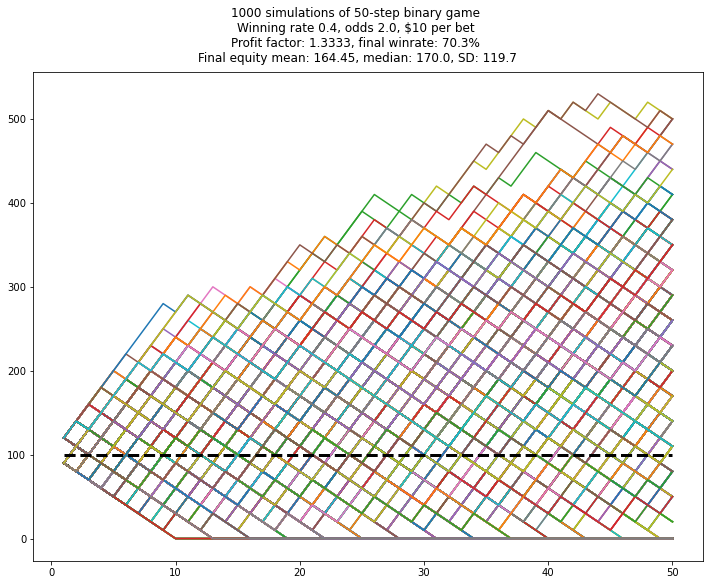

In [7]:
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a1, p1, b1, numTrials1, numSim1)

### Raising winning rate & fix amount-per-bet, profit factor (odds reduced)

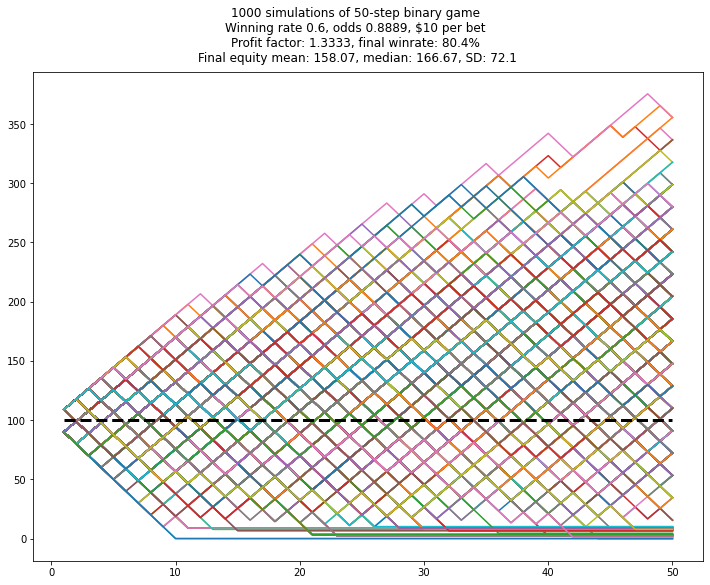

In [8]:
profitfactor1 = 4 / 3
p2 = 0.6   
b2 = getOdds(p2, profitfactor1)

plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a1, p2, b2, numTrials1, numSim1)

### Fix p & b, vary amount-per-bet

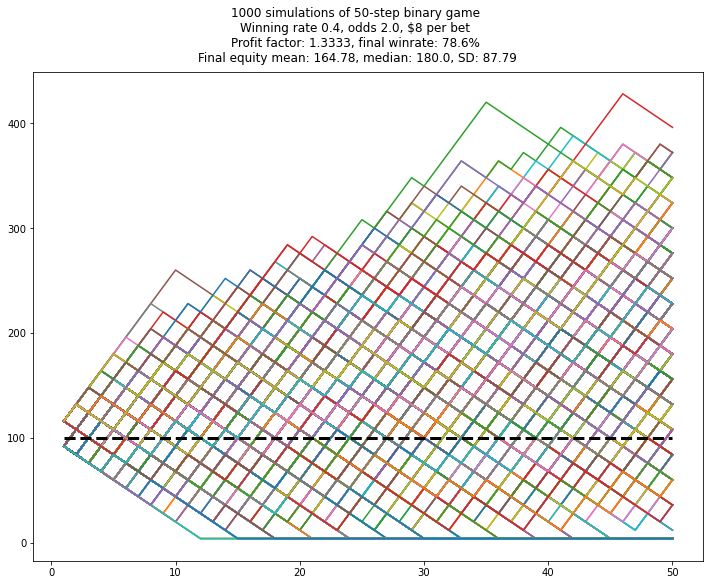

In [9]:
a2 = 8
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a2, p1, b1, numTrials1, numSim1)

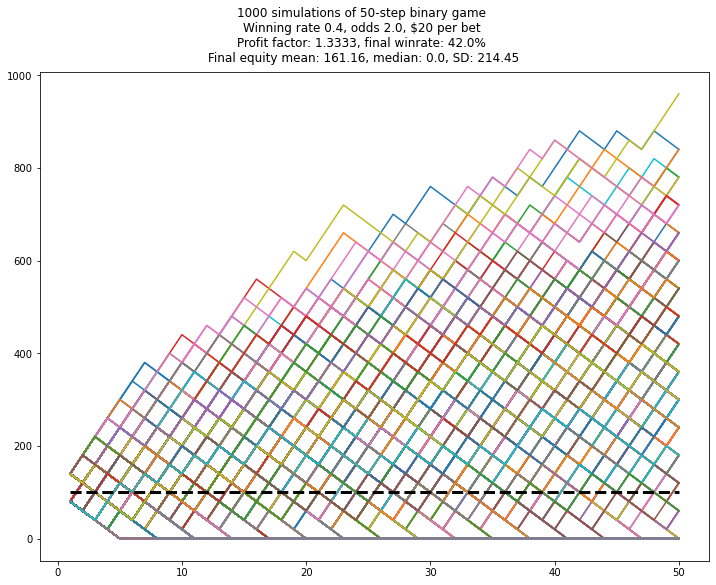

In [10]:
a3 = 20
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a3, p1, b1, numTrials1, numSim1)

## Risk control & ruin

### Risk of ruin & MDD in a simulation

In [11]:
def getRuin(dfSim, initAmount=100, numTrial=50, level=0.1):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""   
    return dfSim[dfSim[numTrial] <= level*initAmount].shape[0] / dfSim.shape[0]

def getSimMDD(dfSim, levelsMDD=(0.2, 0.5, 0.8, 0.9)):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""
    # Transpose the simulation dataframe
    dfSimT = dfSim.transpose()
    numTrial = dfSim.shape[1]
    numSim = dfSim.shape[0]
    # Compute MDD
    dfMDD = pd.DataFrame(columns=dfSimT.columns)
    for col in dfSimT.columns:
        dfMDD[col] = (dfSimT[col] / dfSimT[col].cummax() - 1).cummin()
    # Tranpose back to match original shape
    dfMDD = dfMDD.transpose()
    # Compute percentage of simulations having MDD greater than the levels
    dictMDD = {}
    for value in levelsMDD:
        dictMDD[value] = dfMDD[dfMDD[numTrial] <= -value].shape[0] / numSim

    return dfMDD, dictMDD   

### Using above (p, b) pair and vary number of trials

In [12]:
trialsRange = range(50, 300, 50)  ## Number of betting trials from 50 to 250

for numTrials in trialsRange:
    dfSim = getSim_binaryFixAmount(initAmount1, a1, p1, b1, numTrials, 1000)
    ruin = getRuin(dfSim, initAmount1, numTrials, a1 / initAmount1)
    print(f'\n% of betting series with final equity below amount-per-bet ${a1} after {numTrials} trials: {ruin}\n')
    dfMDD, dictMDD = getSimMDD(dfSim)
    print(f'Percentage of betting series suffering \n')
    
    for key, value in dictMDD.items():
        print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')


% of betting series with final equity below amount-per-bet $10 after 50 trials: 0.167

Percentage of betting series suffering 

20% MDD: 92.2%
50% MDD: 46.9%
80% MDD: 21.6%
90% MDD: 18.3%

% of betting series with final equity below amount-per-bet $10 after 100 trials: 0.243

Percentage of betting series suffering 

20% MDD: 96.8%
50% MDD: 58.3%
80% MDD: 31.6%
90% MDD: 27.0%

% of betting series with final equity below amount-per-bet $10 after 150 trials: 0.241

Percentage of betting series suffering 

20% MDD: 97.8%
50% MDD: 58.9%
80% MDD: 30.4%
90% MDD: 26.8%

% of betting series with final equity below amount-per-bet $10 after 200 trials: 0.2757242757242757

Percentage of betting series suffering 

20% MDD: 97.6%
50% MDD: 60.94%
80% MDD: 34.27%
90% MDD: 29.47%

% of betting series with final equity below amount-per-bet $10 after 250 trials: 0.266

Percentage of betting series suffering 

20% MDD: 97.9%
50% MDD: 60.2%
80% MDD: 34.0%
90% MDD: 28.9%


### Fix p, b and raise amount-per-bet to 20

In [13]:
for numTrials in trialsRange:
    dfSim = getSim_binaryFixAmount(initAmount1, a3, p1, b1, numTrials, 1000)
    ruin = getRuin(dfSim, initAmount1, numTrials, a3 / initAmount1)
    print(f'\n% of betting series with final equity below amount-per-bet ${a1} after {numTrials} trials: {ruin}\n')
    dfMDD, dictMDD = getSimMDD(dfSim)
    print(f'Percentage of betting series suffering \n')
    
    for key, value in dictMDD.items():
        print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')


% of betting series with final equity below amount-per-bet $10 after 50 trials: 0.543

Percentage of betting series suffering 

20% MDD: 99.0%
50% MDD: 81.6%
80% MDD: 60.5%
90% MDD: 55.6%

% of betting series with final equity below amount-per-bet $10 after 100 trials: 0.584

Percentage of betting series suffering 

20% MDD: 99.7%
50% MDD: 84.6%
80% MDD: 64.8%
90% MDD: 59.8%

% of betting series with final equity below amount-per-bet $10 after 150 trials: 0.628

Percentage of betting series suffering 

20% MDD: 99.6%
50% MDD: 85.7%
80% MDD: 67.1%
90% MDD: 63.5%

% of betting series with final equity below amount-per-bet $10 after 200 trials: 0.5754245754245755

Percentage of betting series suffering 

20% MDD: 99.7%
50% MDD: 85.31%
80% MDD: 63.24%
90% MDD: 58.84%

% of betting series with final equity below amount-per-bet $10 after 250 trials: 0.6393606393606394

Percentage of betting series suffering 

20% MDD: 99.5%
50% MDD: 86.01%
80% MDD: 68.23%
90% MDD: 65.03%


## Fixed p = 0.5, 100 bets (2 year), 1000 sims, varied amount-per-bet and odds

### Simulations

In [14]:
bList = [0.25 * r for r in range(2, 13)]
aList = [25, 20, 15, 10, 5, 2]
initAmount = 100
p = 0.5
numTrials = 100
numSim = 1000

simDict1 = {}
dfProb1 = pd.DataFrame()  # Terminal winning probability
dfAvg1 = pd.DataFrame() # Average final P/L
dfStd1 = pd.DataFrame() # SD of final P/L
dfRuin1 = pd.DataFrame()  # Risk of ruin

for b, a in product(bList, aList):
    dfSim, kpiDict = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount, a, p, b, numTrials, numSim)
    simDict1[(p, b, a)] = dfSim
    dfProb1.loc[f'${a}', b] = kpiDict['win%']
    dfAvg1.loc[f'${a}', b] = kpiDict['avgAmount'] - initAmount
    dfStd1.loc[f'${a}', b] = kpiDict['stdAmount'] 
    dfRuin1.loc[f'${a}', b] = getRuin(dfSim, initAmount, numTrials, level=a / initAmount)

### Terminal winning probability

In [16]:
dfProb1[(dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,28.5,52.9,62.5,71.6,73.4,78.5,80.9,85.2
$20,NaN,NaN,NaN,41.3,60.5,71.8,83.8,83.7,89.1,89.2,87.4
$15,NaN,NaN,NaN,50.9,78.5,86.2,87.5,92.9,95.4,93.3,95.7
$10,NaN,NaN,NaN,71.7,89.9,97.3,97.6,99.0,98.6,99.6,100.0
$5,NaN,NaN,NaN,86.2,98.0,99.8,100.0,100.0,100.0,100.0,100.0
$2,NaN,NaN,NaN,87.1,97.7,99.7,99.9,100.0,100.0,100.0,100.0


### Average terminal P/L

In [17]:
dfAvg1[(dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,68.05,326.84,590.33,896.83,1131.46,1484.41,1779.61,2117.70
$20,NaN,NaN,NaN,93.25,296.77,546.53,833.92,1063.49,1336.13,1554.43,1744.04
$15,NaN,NaN,NaN,76.30,296.89,494.68,655.39,864.10,1055.89,1217.42,1438.71
$10,NaN,NaN,NaN,89.89,230.08,361.56,487.61,614.00,746.11,870.43,995.84
$5,NaN,NaN,NaN,62.60,121.97,189.98,248.45,313.25,377.29,434.01,495.18
$2,NaN,NaN,NaN,24.91,50.10,76.01,99.12,124.94,151.11,174.30,199.74


### SD of terminal P/L

In [18]:
dfStd1[(dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,278.03,450.31,586.76,705.63,815.55,912.67,1001.32,1029.76
$20,NaN,NaN,NaN,249.89,363.71,455.56,491.65,587.49,600.51,665.96,798.10
$15,NaN,NaN,NaN,186.06,252.87,297.22,346.82,350.78,353.19,439.81,438.36
$10,NaN,NaN,NaN,134.76,156.67,150.25,169.27,177.40,208.13,196.97,205.83
$5,NaN,NaN,NaN,57.44,61.95,69.28,73.11,80.06,86.09,93.56,101.40
$2,NaN,NaN,NaN,21.80,25.94,27.34,29.64,32.06,34.69,38.82,39.29


### Risk-of-ruin

In [19]:
dfRuin1[(dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,0.71200,0.471,0.375624,0.284,0.266000,0.215,0.191,0.148
$20,NaN,NaN,NaN,0.58042,0.394,0.282000,0.162,0.163000,0.109,0.108,0.126
$15,NaN,NaN,NaN,0.47100,0.212,0.138000,0.125,0.071928,0.046,0.067,0.043
$10,NaN,NaN,NaN,0.23400,0.097,0.027000,0.022,0.010000,0.014,0.004,0.000
$5,NaN,NaN,NaN,0.01200,0.002,0.000000,0.000,0.000000,0.000,0.000,0.000
$2,NaN,NaN,NaN,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000,0.000


## Fixed odds = 1, 100 bets (2 year), 1000 sims, varied amount-per-bet and winning rate

### Simulations

In [20]:
pList = np.arange(0.25, 0.75, 0.05)
aList = [25, 20, 15, 10, 5, 2]

initAmount = 100
b = 1.0
numTrials = 100
numSim = 1000

simDict2 = {}
dfProb2 = pd.DataFrame()  # Terminal winning probability
dfAvg2 = pd.DataFrame() # Average final P/L
dfStd2 = pd.DataFrame() # SD of final P/L
dfRuin2 = pd.DataFrame()  # Risk of ruin

for p, a in product(pList, aList):
    dfSim, kpiDict = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount, a, p, b, numTrials, numSim)
    simDict2[(p, b, a)] = dfSim
    pct = round(100 * p)
    dfProb2.loc[f'${a}', f'{pct}%'] = kpiDict['win%']
    dfAvg2.loc[f'${a}', f'{pct}%'] = kpiDict['avgAmount'] - initAmount
    dfStd2.loc[f'${a}', f'{pct}%'] = kpiDict['stdAmount'] 
    dfRuin2.loc[f'${a}', f'{pct}%'] = getRuin(dfSim, initAmount, numTrials, level=a / initAmount)

### Terminal winning probability

In [21]:
dfProb2[(dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,36.0,63.9,84.6,94.2
$20,NaN,NaN,NaN,NaN,NaN,NaN,44.1,74.8,91.0,96.4
$15,NaN,NaN,NaN,NaN,NaN,NaN,52.4,84.3,95.3,99.2
$10,NaN,NaN,NaN,NaN,NaN,NaN,76.7,96.2,99.8,100.0
$5,NaN,NaN,NaN,NaN,NaN,NaN,87.7,98.2,100.0,100.0
$2,NaN,NaN,NaN,NaN,NaN,56.1,84.8,98.7,99.9,100.0


### Average Terminal P/L

In [22]:
dfAvg2[(dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,67.35,314.49,638.15,952.85
$20,NaN,NaN,NaN,NaN,NaN,NaN,66.12,298.18,548.56,763.04
$15,NaN,NaN,NaN,NaN,NaN,NaN,67.80,249.48,427.47,600.39
$10,NaN,NaN,NaN,NaN,NaN,NaN,78.76,192.52,300.88,397.50
$5,NaN,NaN,NaN,NaN,NaN,NaN,50.46,100.60,150.48,199.84
$2,NaN,NaN,NaN,NaN,NaN,0.87,19.41,41.01,60.01,79.68


### SD Terminal P/L

In [23]:
dfStd2[(dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,256.16,365.84,376.73,342.33
$20,NaN,NaN,NaN,NaN,NaN,NaN,213.09,279.32,272.96,243.91
$15,NaN,NaN,NaN,NaN,NaN,NaN,172.90,192.31,172.92,151.24
$10,NaN,NaN,NaN,NaN,NaN,NaN,114.93,106.57,97.20,92.93
$5,NaN,NaN,NaN,NaN,NaN,NaN,48.94,49.81,48.62,46.18
$2,NaN,NaN,NaN,NaN,NaN,19.76,20.40,19.33,18.73,18.11


### Risk-of-ruin

In [24]:
dfRuin2[(dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,0.63800,0.360639,0.154,0.058
$20,NaN,NaN,NaN,NaN,NaN,NaN,0.55600,0.251000,0.090,0.036
$15,NaN,NaN,NaN,NaN,NaN,NaN,0.46000,0.152000,0.047,0.008
$10,NaN,NaN,NaN,NaN,NaN,NaN,0.16983,0.032000,0.002,0.000
$5,NaN,NaN,NaN,NaN,NaN,NaN,0.00400,0.002000,0.000,0.000
$2,NaN,NaN,NaN,NaN,NaN,0.0,0.00000,0.000000,0.000,0.000


## Fixed Profit Factor = 1.5, 10 bets, varied amount-per-bet & odds

In [25]:
bList = [0.25 * r for r in range(2, 13)]
aList = [25, 20, 15, 10, 5, 2]

initAmount = 100
profitfactor = 1.5
numTrials = 100
numSim = 1000

simDict3 = {}
dfProb3 = pd.DataFrame()  # Terminal winning probability
dfAvg3 = pd.DataFrame() # Average final P/L
dfStd3 = pd.DataFrame() # SD of final P/L
dfRuin3 = pd.DataFrame()  # Risk of ruin


for b, a in product(bList, aList):
    p = profitfactor / (b + profitfactor)
    dfSim, kpiDict = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount, a, p, b, numTrials, numSim)
    simDict3[(p, b, a)] = dfSim
    pct = round(100 * p)
    dfProb3.loc[f'${a}', f'{pct}%'] = kpiDict['win%']
    dfAvg3.loc[f'${a}', f'{pct}%'] = kpiDict['avgAmount'] - initAmount
    dfStd3.loc[f'${a}', f'{pct}%'] = kpiDict['stdAmount'] 
    dfRuin3.loc[f'${a}', f'{pct}%'] = getRuin(dfSim, initAmount, numTrials, level=a / initAmount)

### Terminal winning probabilities

In [26]:
dfProb3[(dfAvg3 > 0)]

,75%,67%,60%,55%,50%,46%,43%,40%,38%,35%,33%
$25,73.6,64.2,65.6,56.8,50.7,42.6,45.4,36.7,34.9,32.6,36.4
$20,83.8,78.4,74.5,64.5,58.8,55.7,54.0,48.9,45.8,42.9,42.9
$15,91.9,87.7,81.6,79.7,76.4,74.5,65.3,62.2,60.8,55.5,49.6
$10,96.3,96.2,96.5,93.9,92.1,89.4,85.7,83.8,81.8,76.8,78.9
$5,96.5,97.1,98.1,97.9,97.5,97.1,96.5,97.3,96.7,94.4,96.0
$2,97.7,97.5,98.6,98.5,97.8,97.1,96.7,97.5,96.9,97.1,97.5


### Average Terminal P/L

In [27]:
dfAvg3[(dfAvg3 > 0)]

,75%,67%,60%,55%,50%,46%,43%,40%,38%,35%,33%
$25,221.65,253.85,324.03,329.28,316.85,275.69,309.92,263.68,256.77,243.66,284.42
$20,216.73,259.44,294.10,275.77,286.16,294.74,304.48,289.89,282.09,280.63,272.33
$15,172.81,222.03,244.20,272.32,283.01,308.60,265.11,274.26,283.18,268.88,231.82
$10,125.11,163.56,200.48,212.37,226.13,249.45,246.86,261.88,250.76,246.73,256.66
$5,61.75,85.24,98.78,113.47,123.34,135.00,142.78,151.60,153.82,156.39,165.52
$2,25.43,33.16,40.75,46.05,50.08,53.64,56.81,61.17,61.04,66.25,66.92


### SD Terminal P/L

In [28]:
dfStd3[(dfAvg3 > 0)]

,75%,67%,60%,55%,50%,46%,43%,40%,38%,35%,33%
$25,224.91,291.35,356.83,417.15,454.70,468.49,498.25,518.03,524.16,536.39,560.93
$20,173.50,221.76,280.29,316.12,363.60,394.29,421.15,437.99,459.37,478.28,479.61
$15,112.22,155.71,197.48,230.68,259.37,285.90,305.48,328.31,356.25,372.18,373.08
$10,67.40,85.91,105.86,125.68,147.94,170.04,189.95,207.21,216.32,233.75,239.37
$5,32.84,41.47,50.33,56.20,64.96,69.69,77.04,79.54,87.77,97.70,102.74
$2,12.91,16.46,19.05,21.97,24.59,27.17,29.45,33.26,33.69,36.26,37.75


### Risk-of-ruin

In [29]:
dfRuin3

,75%,67%,60%,55%,50%,46%,43%,40%,38%,35%,33%
$25,0.260,0.35700,0.343656,0.431568,0.493000,0.574,0.544456,0.633,0.649,0.674,0.636364
$20,0.151,0.21000,0.254000,0.353000,0.410000,0.442,0.458000,0.508,0.540,0.570,0.571429
$15,0.070,0.10989,0.182000,0.198000,0.233766,0.252,0.344000,0.376,0.389,0.444,0.504496
$10,0.006,0.01900,0.024000,0.049000,0.073000,0.097,0.131000,0.154,0.182,0.224,0.209000
$5,0.000,0.00000,0.000000,0.000000,0.004000,0.004,0.008000,0.004,0.017,0.020,0.030000
$2,0.000,0.00000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000,0.000,0.000000
